### Data Link
* https://www.kaggle.com/datasets/die9origephit/nike-adidas-and-converse-imaged

## Importing libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import imagenet_utils

import itertools
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Setting up parameters

In [2]:
im_shape = (250,250)

TRAINING_DIR = './train'
TEST_DIR = './test'

seed = 123

BATCH_SIZE = 32

## Data Augmentation

In [3]:
# Subdivision in test/validation
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [4]:
data_generator = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

### Train, Validation and test data

In [5]:
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")


test_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 570 images belonging to 3 classes.
Found 141 images belonging to 3 classes.
Found 114 images belonging to 3 classes.
Classes: ['adidas', 'converse', 'nike']


In [6]:
for each in test_generator:
    print(each[0].shape) ## Image batch
    print(each[1].shape) ## Image label
    break

(32, 250, 250, 3)
(32, 3)


## Visualizing some examples

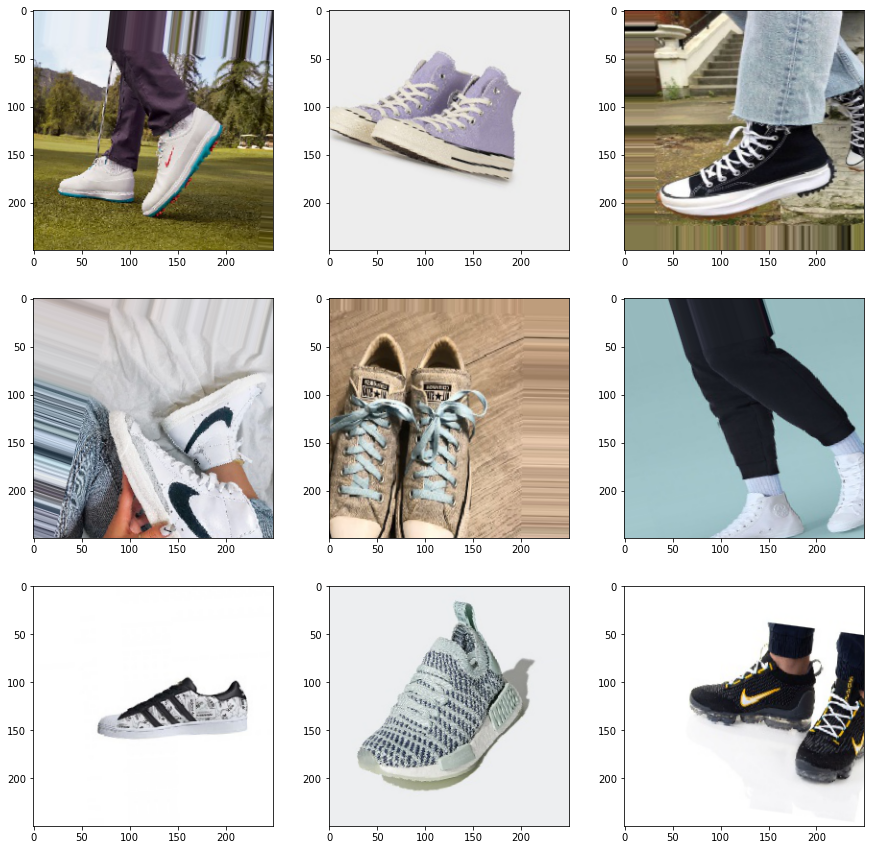

In [7]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [17]:
model = Sequential([
  keras.layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(250,250,3)),
  keras.layers.MaxPooling2D(pool_size=(2,2)),
  keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2,2)),
  keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2,2)),
  keras.layers.Dropout(0.2),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes, name="outputs", activation='softmax')
])

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 125, 125, 16)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 31, 31, 64)      

## The below model gets 49% Accuracy

In [10]:
model = Sequential()
model.add(Conv2D(20, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(250,250,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(40, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 248, 248, 20)      560       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 124, 124, 20)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 40)      7240      
                                                                 
 flatten_1 (Flatten)         (None, 595360)            0         
                                                                 
 dense_2 (Dense)             (None, 100)               59536100  
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                      

In [18]:
epochs = 80

#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/80
17/17 [==============================] - ETA: 0s - loss: 2.0473 - accuracy: 0.3086
Epoch 1: val_loss improved from inf to 1.09833, saving model to model.h5
17/17 [==============================] - 38s 2s/step - loss: 2.0473 - accuracy: 0.3086 - val_loss: 1.0983 - val_accuracy: 0.3672
Epoch 2/80
17/17 [==============================] - ETA: 0s - loss: 1.0998 - accuracy: 0.3383
Epoch 2: val_loss did not improve from 1.09833
17/17 [==============================] - 36s 2s/step - loss: 1.0998 - accuracy: 0.3383 - val_loss: 1.0992 - val_accuracy: 0.2656
Epoch 3/80
17/17 [==============================] - ETA: 0s - loss: 1.0906 - accuracy: 0.3606
Epoch 3: val_loss did not improve from 1.09833
17/17 [==============================] - 36s 2s/step - loss: 1.0906 - accuracy: 0.3606 - val_loss: 1.1207 - val_accuracy: 0.2578
Epoch 4/80
17/17 [==============================] - ETA: 0s - loss: 1.0863 - accuracy: 0.3792
Epoch 4: val_loss did not improve from 1.09833
17/17 [================

Epoch 30/80
17/17 [==============================] - ETA: 0s - loss: 0.8112 - accuracy: 0.6338
Epoch 30: val_loss did not improve from 0.90895
17/17 [==============================] - 36s 2s/step - loss: 0.8112 - accuracy: 0.6338 - val_loss: 1.0006 - val_accuracy: 0.5312
Epoch 31/80
17/17 [==============================] - ETA: 0s - loss: 0.8085 - accuracy: 0.6468
Epoch 31: val_loss did not improve from 0.90895
17/17 [==============================] - 36s 2s/step - loss: 0.8085 - accuracy: 0.6468 - val_loss: 1.0903 - val_accuracy: 0.5078
Epoch 32/80
17/17 [==============================] - ETA: 0s - loss: 0.8605 - accuracy: 0.6115
Epoch 32: val_loss improved from 0.90895 to 0.87764, saving model to model.h5
17/17 [==============================] - 37s 2s/step - loss: 0.8605 - accuracy: 0.6115 - val_loss: 0.8776 - val_accuracy: 0.5703
Epoch 33/80
17/17 [==============================] - ETA: 0s - loss: 0.8297 - accuracy: 0.6152
Epoch 33: val_loss did not improve from 0.87764
17/17 [====

Epoch 60/80
17/17 [==============================] - ETA: 0s - loss: 0.6216 - accuracy: 0.7342
Epoch 60: val_loss did not improve from 0.83088
17/17 [==============================] - 30s 2s/step - loss: 0.6216 - accuracy: 0.7342 - val_loss: 0.8942 - val_accuracy: 0.5938
Epoch 61/80
17/17 [==============================] - ETA: 0s - loss: 0.6239 - accuracy: 0.7398
Epoch 61: val_loss did not improve from 0.83088
17/17 [==============================] - 30s 2s/step - loss: 0.6239 - accuracy: 0.7398 - val_loss: 1.0224 - val_accuracy: 0.6016
Epoch 61: early stopping


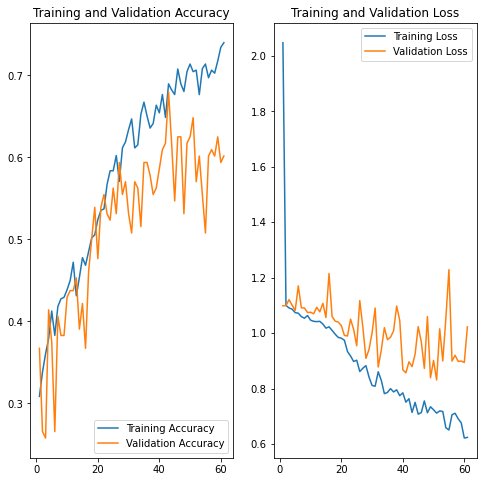

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [82]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<ipython-input-83-4a63cf876f11>:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)


Classification Report
              precision    recall  f1-score   support

      adidas       0.69      0.47      0.56        38
    converse       0.60      0.89      0.72        38
        nike       0.68      0.55      0.61        38

    accuracy                           0.64       114
   macro avg       0.66      0.64      0.63       114
weighted avg       0.66      0.64      0.63       114



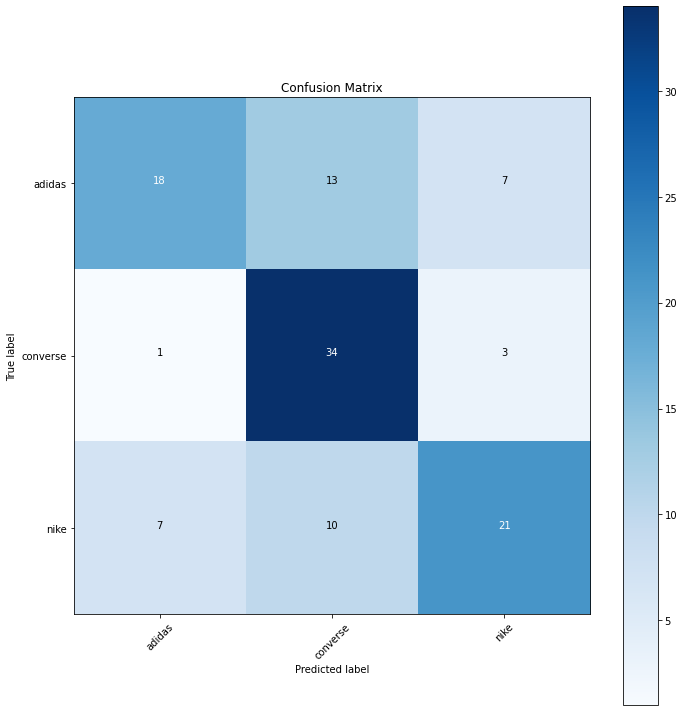

In [83]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#On test dataset
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

#Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

### Predict new data

In [116]:
test_image_batch, test_label_batch = test_generator.next()
predictions = model.predict_on_batch(test_image_batch)
y_pred = []
predictions = tf.nn.softmax(predictions)
print(predictions)
print('Labels:\n', test_label_batch)


tf.Tensor(
[[0.2153287  0.57146066 0.21321061]
 [0.21734592 0.55870736 0.22394677]
 [0.27255172 0.50179076 0.2256575 ]
 [0.21771455 0.23157892 0.5507065 ]
 [0.2123328  0.57552785 0.2121393 ]
 [0.26424816 0.4882915  0.24746022]
 [0.2152763  0.5601972  0.22452657]
 [0.26050985 0.48871544 0.25077468]
 [0.24554163 0.52132416 0.23313421]
 [0.32049236 0.26305428 0.4164534 ]
 [0.21762556 0.55038464 0.23198989]
 [0.21212532 0.57587343 0.21200126]
 [0.23422831 0.26423892 0.5015328 ]
 [0.30714983 0.41110584 0.2817443 ]
 [0.39348313 0.30078307 0.3057338 ]
 [0.55232775 0.21734172 0.23033054]
 [0.21204384 0.21226895 0.5756872 ]
 [0.22798212 0.27573156 0.49628627]
 [0.24531536 0.5117933  0.24289134]
 [0.23558033 0.35359126 0.41082847]
 [0.21539687 0.22497398 0.55962914]
 [0.2670368  0.2398479  0.49311522]
 [0.40196797 0.27406678 0.32396516]
 [0.26986092 0.25565603 0.47448304]
 [0.26235655 0.3566867  0.38095674]
 [0.33172902 0.32410556 0.3441654 ]
 [0.229216   0.52781737 0.24296659]
 [0.23855945 0.49

In [91]:
predict= model.predict(test_generator, verbose = 1)

4/4 [==============================] - 1s 143ms/step


In [92]:
len(predict)

114

In [93]:
predicted_class_indices=np.argmax(predict,axis=1)

In [94]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [104]:
img_uri = 'C:/Users/saras/Desktop/shoes_detection/test.jpg'
img = tf.keras.utils.load_img(
    img_uri, target_size=(250, 250)
)

print(type(img))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(classes[np.argmax(score)], 100 * np.max(score))
)

<class 'PIL.Image.Image'>
1/1 [==============================] - 0s 25ms/step
This image most likely belongs to nike with a 57.61 percent confidence.


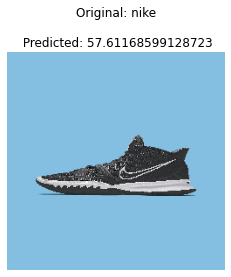

In [111]:
plt.imshow(img)
plt.title(f"Original: {classes[np.argmax(score)]}\n\n Predicted: {np.max(score) * 100}")
plt.axis("off")
plt.show()

### Evaluate the Model

In [35]:
print("We got an accuracy of {:.2f}%".format(model.evaluate(test_generator)[1]*100))

4/4 [==============================] - 1s 355ms/step - loss: 0.8779 - accuracy: 0.6404
We got an accuracy of 64.04%


In [43]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(test_generator)
print("predictions shape:", predictions.shape)

Generate predictions for 3 samples
4/4 [==============================] - 1s 179ms/step
predictions shape: (114, 3)


Some of the common pre-trained models for image classification and computer vision are **Inceptionv3**, **ResNet50**, **VGG-16**, **EfficientNet**, **AlexNet**, **LeNet**, and **MobileNet**.

### Using mobileNet Model

In [18]:
train_set = tf.keras.utils.image_dataset_from_directory(
TRAINING_DIR,
validation_split = 0.2,
seed = 123,
batch_size = BATCH_SIZE,
image_size =im_shape,
subset='training')

valid_set = tf.keras.utils.image_dataset_from_directory(
TRAINING_DIR,
validation_split = 0.2,
seed = 123,
batch_size = BATCH_SIZE,
image_size =im_shape,
subset='validation')

Found 711 files belonging to 3 classes.
Using 569 files for training.
Found 711 files belonging to 3 classes.
Using 142 files for validation.


In [16]:
test_set = tf.keras.utils.image_dataset_from_directory(TEST_DIR, shuffle=True, validation_split=0.2, subset='training', seed=123, batch_size=BATCH_SIZE, image_size=im_shape)

Found 114 files belonging to 3 classes.
Using 92 files for training.


In [19]:
class_names = train_set.class_names
class_names

['adidas', 'converse', 'nike']

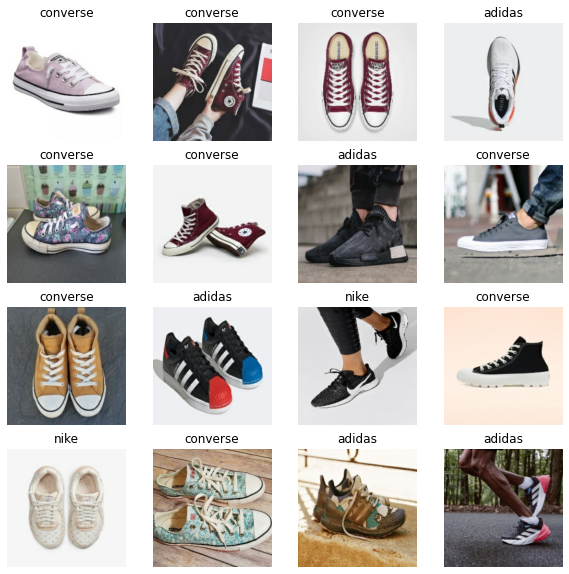

In [20]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [21]:
## Data Augmentation
data_augment = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'),
                               tf.keras.layers.RandomRotation(0.2),
                               tf.keras.layers.RandomZoom(0.1)])

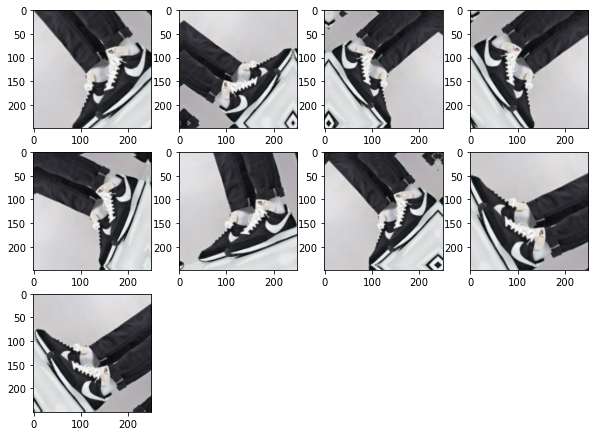

In [22]:
for image, _ in train_set.take(1):
    plt.figure(figsize=(10, 10))
    img = image[16]
    for i in range(9):
        ax = plt.subplot(4, 4, i + 1)
        augmented_image = data_augment(tf.expand_dims(img, 0))
        plt.imshow(augmented_image[0] / 255)

**As we are using a pre-trained model, the mobilenet_v2 expects our images to be normalized i.e. the pixel values should be in between [0, 255], so we will use the preprocess_input method of the mobilenet model to preprocess our data.**

In [23]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [24]:
IMG_SHAPE = im_shape + (3,)
IMG_SHAPE

(250, 250, 3)

In [25]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 18s 2us/step


In [26]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 125, 125, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 125, 125, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 63, 63, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 65, 65, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 32, 32, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 32, 32, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 16, 16, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 16, 16, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 16, 16, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 16, 16, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 16, 16, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 16, 16, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 16, 16, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 16, 16, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 8, 8, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 8, 8, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 8, 8, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 8, 8, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [27]:
image_batch, label_batch = next(iter(train_set))
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 8, 8, 1280])

In [28]:
base_model.trainable = False

**Global Average pooling layer almost does the work of flatten layer, to reduce the dimension of the feature blocks**

In [29]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


**The output Layer**

In [30]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [31]:
# inputs with shape argument
inputs = tf.keras.Input(shape=IMG_SHAPE)

# Data Augmentation
x = data_augment(inputs)

# Preprocessing (Normalizing) the data
x = preprocess_input(x)

# Freezing the layers
x = base_model(x, training=False)

# Global average pooling to reduce dimensions
x = global_average_layer(x)

# Dropout layer to reduce overfitting
x = tf.keras.layers.Dropout(0.2)(x)

# Output layer
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [32]:
base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 250, 250, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 250, 250, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 250, 250, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

In [36]:
# Using the ModelCheckpoint function to train and store all the best models
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"
checkpoint1 = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]

history = model.fit(train_set,
                    epochs=50,
                    validation_data=valid_set)

Epoch 1/50
18/18 [==============================] - 26s 1s/step - loss: 1.2841 - accuracy: 0.3058 - val_loss: 1.1599 - val_accuracy: 0.3662
Epoch 2/50
18/18 [==============================] - 25s 1s/step - loss: 1.1284 - accuracy: 0.4271 - val_loss: 1.1037 - val_accuracy: 0.4085
Epoch 3/50
18/18 [==============================] - 26s 1s/step - loss: 1.0186 - accuracy: 0.4780 - val_loss: 0.9952 - val_accuracy: 0.4930
Epoch 4/50
18/18 [==============================] - 25s 1s/step - loss: 0.9646 - accuracy: 0.5167 - val_loss: 0.9312 - val_accuracy: 0.5634
Epoch 5/50
18/18 [==============================] - 26s 1s/step - loss: 0.8782 - accuracy: 0.5958 - val_loss: 0.8798 - val_accuracy: 0.5915
Epoch 6/50
18/18 [==============================] - 25s 1s/step - loss: 0.8041 - accuracy: 0.6327 - val_loss: 0.8442 - val_accuracy: 0.5986
Epoch 7/50
18/18 [==============================] - 26s 1s/step - loss: 0.7937 - accuracy: 0.6415 - val_loss: 0.8232 - val_accuracy: 0.5986
Epoch 8/50
18/18 [==

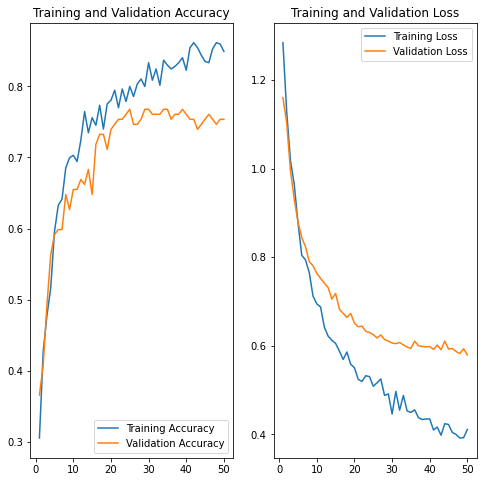

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()